In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# env
import gym

# utils
import imageio
from IPython.display import Image, HTML, clear_output
import logging
import matplotlib.pyplot as plt
import numpy as np

# model
import tensorflow as tf
from tensorflow.keras import backend as K

saveImgs = True

%matplotlib inline 

# Get Pong env

In [3]:
env = gym.make('Pong-v0')
gym.logger.setLevel(logging.ERROR)

# Useful functions

In [4]:
def run_episodes(env, policy):
    frames = []
    observation = env.reset()
    done = False
    while not done:
        frames.append(env.render(mode='rgb_array'))
        if hasattr(policy, 'model'):
            action = policy.decide(observation)
        else:
            action = policy(env, observation)
        observation, reward, done, info = env.step(action)
    return frames

## Random policy test

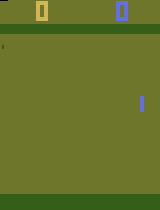

In [5]:
def random_policy(env, observation):
    return env.action_space.sample()
episodes = run_episodes(env, random_policy)
if saveImgs:
    imageio.mimsave('imgs/pong_random_policy.gif', episodes, fps=45)
Image("imgs/pong_random_policy.gif")

# Test wrappers

In [6]:
from common.openai_wrappers import *
import gym
import numpy as np

In [7]:
env = gym.make("Pong-v0")
env.reset()
env

<TimeLimit<AtariEnv<Pong-v0>>>

In [8]:
env.step(0)[0].shape, np.min(env.step(0)[0]), np.max(env.step(0)[0])

((210, 160, 3), 0, 236)

### Rescale from 0 to 1

In [9]:
env = ScaledFrom0To1Wrapper(env)
env.reset()
env

<ScaledFrom0To1Wrapper<TimeLimit<AtariEnv<Pong-v0>>>>

In [10]:
env.step(0)[0].shape, np.min(env.step(0)[0]), np.max(env.step(0)[0])

((210, 160, 3), 0.0, 0.9254902)

### Skip 4 frames and get max from last 2 to avoid blink

In [11]:
env = Skip4FramesAndReturnMaxFrom2FramesWrapper(env)
env.reset()
env

<Skip4FramesAndReturnMaxFrom2FramesWrapper<ScaledFrom0To1Wrapper<TimeLimit<AtariEnv<Pong-v0>>>>>

In [12]:
env.step(0)[0].shape, np.min(env.step(0)[0]), np.max(env.step(0)[0])

((210, 160, 3), 0.0, 0.9254902)

### 210x160x3 to 84x84x1

In [13]:
env = Res84x84x1Wrapper(env)
env.reset()
env

<Res84x84x1Wrapper<Skip4FramesAndReturnMaxFrom2FramesWrapper<ScaledFrom0To1Wrapper<TimeLimit<AtariEnv<Pong-v0>>>>>>

In [14]:
env.step(0)[0].shape, np.min(env.step(0)[0]), np.max(env.step(0)[0])

((84, 84), 0.34218827, 0.92549026)

### stack last 4 frames

In [15]:
env = StackLast4Wrapper(env)
env.reset()
env

<StackLast4Wrapper<Res84x84x1Wrapper<Skip4FramesAndReturnMaxFrom2FramesWrapper<ScaledFrom0To1Wrapper<TimeLimit<AtariEnv<Pong-v0>>>>>>>

In [16]:
env.step(0)[0].shape, np.min(env.step(0)[0]), np.max(env.step(0)[0])

((84, 84, 4), 0.0, 0.92549026)

### test all

In [17]:
# initial environment
env = gym.make("Pong-v0")
env.reset()
env

<TimeLimit<AtariEnv<Pong-v0>>>

In [19]:
f'Environment shape: {env.step(0)[0].shape}, min: {np.min(env.step(0)[0])}, max: {np.max(env.step(0)[0])}'

'Environment shape: (210, 160, 3), min: 0, max: 236'

In [20]:
# modified environment
env = apply_all_wrappers(env)
env

<StackLast4Wrapper<Res84x84x1Wrapper<Skip4FramesAndReturnMaxFrom2FramesWrapper<ScaledFrom0To1Wrapper<TimeLimit<AtariEnv<Pong-v0>>>>>>>

In [21]:
f'Environment shape: {env.step(0)[0].shape}, min: {np.min(env.step(0)[0])}, max: {np.max(env.step(0)[0])}'

'Environment shape: (84, 84, 4), min: 0.0, max: 0.9254902601242065'

# Training

In [1]:
from models import dqn_2013
from common.openai_wrappers import *

import gym

In [12]:
env = gym.make("Pong-v0")
env = apply_all_wrappers(env)
state = env.reset()
env

<StackLast4Wrapper<Res84x84x1Wrapper<Skip4FramesAndReturnMaxFrom2FramesWrapper<ScaledFrom0To1Wrapper<TimeLimit<AtariEnv<Pong-v0>>>>>>>

In [3]:
env.observation_space.shape[0], env.action_space.n

(210, 6)

In [23]:
# action space meaning
env.unwrapped.get_action_meanings()

['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']

In [7]:
main_dqn_model = dqn_2013.DQN(
    env.observation_space.shape[0],
    env.action_space.n)

In [8]:
# used to make training more stable
tmp_dqn_model = dqn_2013.DQN(
    env.observation_space.shape[0],
    env.action_space.n)

In [9]:
# buffer to sample the last N observation state/action/reward/done/new_state
BUFFER_SIZE = 1000
buffer = collections.deque(maxlen=BUFFER_SIZE)

In [29]:
def take_action(model, env, state, epsilon=0.0):

        if np.random.random() < epsilon:
            action = env.action_space.sample()
        else:
            model_input = np.array(state)
            model_output = model(model_input)
            action = np.argmax(model_output, axis=1)

        return env.step(action)

In [35]:
next_state, reward, done, _ = take_action(
    main_dqn_model, env, np.expand_dims(state, axis=0))